### Setup Freyberg pilot points to use regularization and see what happens...

With our first attempt at pilot points, we saw shitty results.  So lets see if we can fix the problem by using regularization

In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_2/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S.

/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat
starting interp point loop for 800 points
took 2.744466 seconds
run():./pestchek freyberg_pp.pst
run():./pestpp freyberg_pp.init.pst


In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In the ``intro_to_regularization``, we talked about two common forms of regularization.  Here we will add both types to the control file.  

Now let's add a few preferred value equations for the recharge and well flux parameters:

In [4]:
pst.parameter_data.pargp.unique()

array(['rch', 'hk', 'w0', 'w1'], dtype=object)

In [5]:
#pyemu.helpers.zero_order_tikhonov(pst,par_groups=["rch","w0","w1"])
pyemu.helpers.zero_order_tikhonov(pst)

In [6]:
pst.prior_information

,equation,obgnme,pilbl,weight
pilbl,,,,
rch_0,1.0 * log(rch_0) = 0.000000E+00,regulrch,rch_0,4.507576
rch_1,1.0 * log(rch_1) = 0.000000E+00,regulrch,rch_1,4.507576
hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,hk00,0.500000
hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,hk01,0.500000
hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,hk02,0.500000
hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,hk03,0.500000
hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,hk04,0.500000
hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,hk05,0.500000
hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,hk06,0.500000


Now, let's add preferred differnce regularization to the spatially distributed parameters

In [7]:
# v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
# gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
# df_pp = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
# cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)
# pyemu.helpers.first_order_pearson_tikhonov(pst,cov,reset=False)
# pst.prior_information

Now we need to adjust the inputs to pest the control how regularization is enforced.  The big knob is ``phimlim``.  But first, we need to change the estimation mode to "regularization"

In [8]:
pst.control_data.pestmode = "regularization"
pst.reg_data.phimlim

1e-10

That's no good - way too low.  Theoritically, it should be the number of non-zero weighted obs, so let's start there:

In [9]:
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.nnz_obs * 1.1

In [10]:
pst.write(os.path.join(working_dir,pst_name))

In [11]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=10,master_dir='.')
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9


In [12]:
os.chdir(working_dir)
pst.parrep(pst_name.replace(".pst",".parb"))
pyemu.pst_utils.write_parvals_in_tplfiles(pst)
pyemu.gw_utils.fac2real("hkpp.dat",factors_file="hkpp.dat.fac",out_file="hk_layer_1.ref")
os.chdir("..")

In [13]:
pst.phi, pst.nnz_obs

(54.964363400387406, 14)

Hmm...still not getting to the theorical (error-based) phi value...why? 

Let's see how the parameter values look

In [14]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)

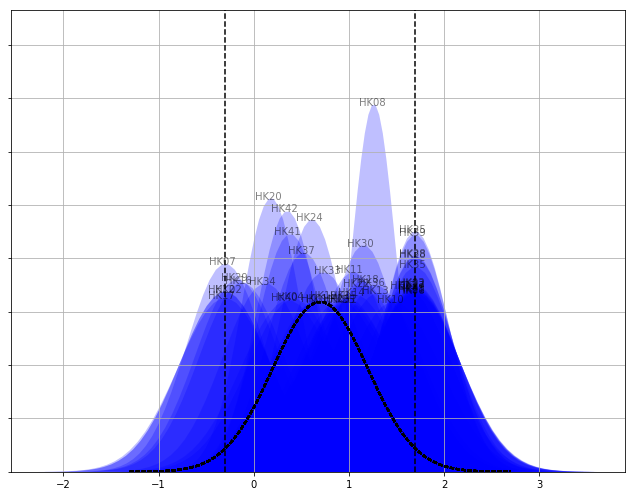

In [15]:
hk_pars = [p.upper() for p in pst.par_names if p.startswith("hk")]
df_hk = df_paru.loc[hk_pars,:]
ax = pyemu.helpers.plot_summary_distributions(df_hk,label_post=True)
mn = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parlbnd"])
mx = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parubnd"])
ax.plot([mn,mn],ax.get_ylim(),"k--")
ax.plot([mx,mx],ax.get_ylim(),"k--")

Not a good sign...lots of parameters are at their bounds...

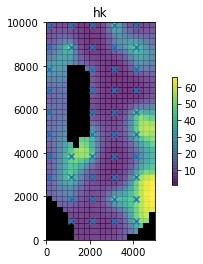

In [17]:
df_pp = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

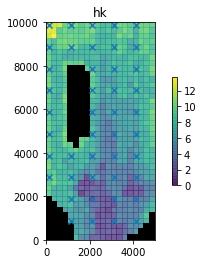

In [18]:
m.upw.hk[0] = os.path.join(fs.BASE_MODEL_DIR,"hk.truth.ref")
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

oh no!!!!!  We are still over fit...so let's back off the fit using ``phimilim``

In [29]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.reg_data.phimlim = 120.0
pst.reg_data.phimaccept = 140.0
pst.reg_data.fracphim = 0.75
pst.write(os.path.join(working_dir,pst_name))


In [ ]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=10,master_dir='.')
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9


In [ ]:
os.chdir(working_dir)
pst.parrep(pst_name.replace(".pst",".parb"))
pyemu.pst_utils.write_parvals_in_tplfiles(pst)
pyemu.gw_utils.fac2real("hkpp.dat",factors_file="hkpp.dat.fac",out_file="hk_layer_1.ref")
os.chdir("..")


In [ ]:
pst.phi

In [ ]:
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')